## Temporal correlation between single mRNA segments and total vRNA (Supplementary Figure 8)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
def filterDF(df, repVal=None, moiVal=None, hpiVal=None, moleculeVal=None, segmentVal=None):
    filtered_df = df
    if repVal is not None:
        filtered_df = filtered_df[filtered_df.rep == repVal]
    
    if moiVal is not None:
        filtered_df = filtered_df[filtered_df.moi == moiVal]
    
    if hpiVal is not None:
        filtered_df = filtered_df[filtered_df.hpi == hpiVal]
    
    if moleculeVal is not None:
        filtered_df = filtered_df[filtered_df.molecule == moleculeVal]
    
    if segmentVal is not None:
        filtered_df = filtered_df[filtered_df.segment == segmentVal]
    
    return filtered_df

## Data preprocessing

In [3]:
spots=pd.read_csv("spots.tsv",sep="\t")

In [4]:
# Step 1: Filter groups with at least 5 rows
filtered_spots = spots.groupby(['rep', 'moi', 'hpi', 'fov', 'cell']).filter(lambda x: len(x) >= 5)

# Step 2: Calculate the number of unique cells per group
unique_cells = filtered_spots.groupby(['rep', 'moi', 'hpi', 'fov'])['cell'].transform('nunique')

# Step 3: Assign the calculated unique cells count to a new column
filtered_spots['infected_cells'] = unique_cells

# Step 4: Reset the index
spots1 = filtered_spots.reset_index(drop=True)


In [5]:
# Adjust moi where it is 0.0 to 1.0
spots1['moi'] = np.where(spots1['moi'] == 0.0, 1.0, spots1['moi'])

In [6]:
# Define the order of the segments for reordering
segment_order = ["PB2","PB1","PA","HA","NP","NA","M","NS"]

# Perform the transformations
spots2 = (spots1
    .assign(target=np.where(spots1['target'].str.contains(','), 'multi', spots1['target']))
    .assign(segment=spots1['target'].str.split(' ').str[0],
            molecule=spots1['target'].str.split(' ').str[1])
    .reset_index()
)

In [7]:
# Perform the transformations
spots3 = (spots2
    .assign(segment=pd.Categorical(spots2['segment'], categories=segment_order, ordered=True))
    .groupby(['rep', 'moi', 'hpi', 'fov', 'segment', 'molecule', 'ambiguous', 'infected_cells'],observed=False)
    .agg(spots=('target', 'size'),
         median_intensity=('intensity', 'median'),
         mean_radius=('radius', 'median'))
    .reset_index()
)


In [8]:
spots_summary = (spots3
    .assign(spots_per_infected_cell=lambda df: df['spots'] / df['infected_cells'])
    .reset_index()
)

In [9]:
# Filter for moi > 0
filtered_data = spots_summary[spots_summary['moi'] > 0]

In [10]:
# Group by 'moi', 'hpi', 'segment', 'molecule' and calculate mean of 'spots_per_infected_cell'
filtered_data.loc[:, 'mean_n'] = (filtered_data
    .groupby(['moi', 'hpi', 'segment', 'molecule'], observed=False)['spots_per_infected_cell']
    .transform('mean'))


In [11]:
# Filter out rows where 'segment' is 'missing' or 'multi'
filtered_data = filtered_data[~filtered_data['segment'].isin(['missing', 'multi'])]

In [12]:
filtered_data_mRNA_03=filterDF(filtered_data, repVal=None, moiVal=0.3, hpiVal=None, moleculeVal='mRNA', segmentVal=None)
filtered_data_mRNA_1=filterDF(filtered_data, repVal=None, moiVal=1, hpiVal=None, moleculeVal='mRNA', segmentVal=None)
filtered_data_vRNA_03=filterDF(filtered_data, repVal=None, moiVal=0.3, hpiVal=None, moleculeVal='vRNA', segmentVal=None)
filtered_data_vRNA_1=filterDF(filtered_data, repVal=None, moiVal=1, hpiVal=None, moleculeVal='vRNA', segmentVal=None)

In [13]:
# Group by the specified columns and summarize the data
grouped_data = filtered_data.groupby(['rep', 'moi', 'hpi', 'fov', 'molecule'],observed=False).agg(
    spots=pd.NamedAgg(column='spots', aggfunc='sum'),
    spots_per_infected_cell=pd.NamedAgg(column='spots_per_infected_cell', aggfunc='sum')
).reset_index()

In [14]:
# Further group by 'moi', 'hpi', and 'molecule' and calculate the mean
grouped_data['mean_n'] = grouped_data.groupby(['moi', 'hpi', 'molecule'])['spots_per_infected_cell'].transform('mean')

In [15]:
filtered_grouped_data_mRNA_03=filterDF(grouped_data, repVal=None, moiVal=0.3, hpiVal=None, moleculeVal='mRNA', segmentVal=None)
filtered_grouped_data_mRNA_1=filterDF(grouped_data, repVal=None, moiVal=1, hpiVal=None, moleculeVal='mRNA', segmentVal=None)
filtered_grouped_data_vRNA_03=filterDF(grouped_data, repVal=None, moiVal=0.3, hpiVal=None, moleculeVal='vRNA', segmentVal=None)
filtered_grouped_data_vRNA_1=filterDF(grouped_data, repVal=None, moiVal=1, hpiVal=None, moleculeVal='vRNA', segmentVal=None)

## Calculating the correlation coefficients

In [16]:
# Initialize an empty list to store dictionaries representing rows
df=filtered_data_mRNA_03
moleculeVal='vRNA'
rows = []
moiVal=0.3
for segmentVal in df.segment.unique():
    filtered=filterDF(filtered_data_mRNA_03, repVal=None, moiVal=moiVal, hpiVal=None, moleculeVal=None, segmentVal=segmentVal)
    mean_Segm=filtered.groupby('hpi').first()
    mean_vRNA=filtered_grouped_data_vRNA_03.groupby('hpi').first()
    pearson_corr =stats.pearsonr(mean_Segm['mean_n'],mean_vRNA['mean_n'])
    spearman_corr =stats.spearmanr(mean_Segm['mean_n'],mean_vRNA['mean_n'])
    new_row = {'moi': moiVal, 'molecule': 'total '+moleculeVal, 'segment': segmentVal, 'PearsonCorrelation': pearson_corr[0],'Pearson_p-Value': pearson_corr[1],
               'SpearmanCorrelation': spearman_corr[0],'Spearman_p-Value': spearman_corr[1]}
    rows.append(new_row)
moiVal=1
df=filtered_data_mRNA_1
for segmentVal in df.segment.unique():
    filtered=filterDF(filtered_data_mRNA_1, repVal=None, moiVal=moiVal, hpiVal=None, moleculeVal=None, segmentVal=segmentVal)
    mean_Segm=filtered.groupby('hpi').first()
    mean_vRNA=filtered_grouped_data_vRNA_1.groupby('hpi').first()
    pearson_corr =stats.pearsonr(mean_Segm['mean_n'],mean_vRNA['mean_n'])
    spearman_corr =stats.spearmanr(mean_Segm['mean_n'],mean_vRNA['mean_n'])
    new_row = {'moi': moiVal, 'molecule': 'total '+moleculeVal, 'segment': segmentVal, 'PearsonCorrelation': pearson_corr[0],'Pearson_p-Value': pearson_corr[1],
               'SpearmanCorrelation': spearman_corr[0],'Spearman_p-Value': spearman_corr[1]}
    rows.append(new_row)
# Convert the list of dictionaries to a DataFrame
df_res = pd.DataFrame(rows)

In [17]:
df_res.to_csv('correlation_total_vRNA.csv')

## Plotting the results

In [18]:
df_res_raw=pd.read_csv('correlation_total_vRNA.csv',index_col=0)

In [19]:
df_res_raw.segment=df_res_raw.segment.fillna('NA')
df_res=df_res_raw.dropna()

In [20]:
df_res

,moi,molecule,segment,PearsonCorrelation,Pearson_p-Value,SpearmanCorrelation,Spearman_p-Value
0,0.3,total vRNA,PB2,0.591697,0.093274,0.366667,0.331740
1,0.3,total vRNA,PB1,0.794355,0.010550,0.583333,0.099186
2,0.3,total vRNA,PA,0.505629,0.164937,0.266667,0.487922
3,0.3,total vRNA,HA,0.553960,0.121724,0.400000,0.286105
4,0.3,total vRNA,NP,0.609360,0.081511,0.616667,0.076929
5,0.3,total vRNA,NA,0.786723,0.011890,0.583333,0.099186
6,0.3,total vRNA,M,0.889488,0.001324,0.500000,0.170471
7,0.3,total vRNA,NS,0.281964,0.462295,0.033333,0.932157
8,1.0,total vRNA,PB2,0.275081,0.473755,0.183333,0.636820
9,1.0,total vRNA,PB1,0.403750,0.281186,0.333333,0.380713


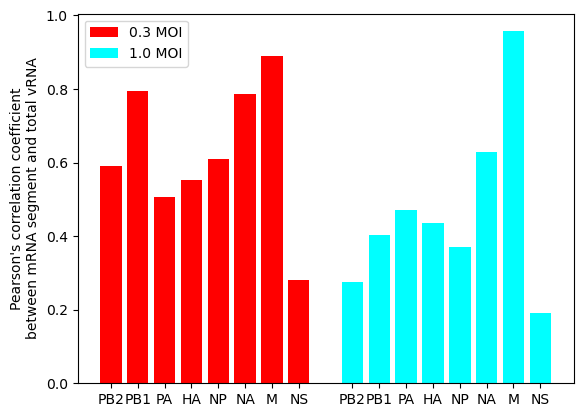

In [21]:
x=np.arange(8)
plt.bar(x,df_res[df_res['moi']==0.3].PearsonCorrelation, label='0.3 MOI',color='red')
plt.bar(x+9,df_res[df_res['moi']==1].PearsonCorrelation,label='1.0 MOI',color='cyan')
plt.xticks(list(x)+list(x+9), df_res.segment)
plt.ylabel('Pearson\'s correlation coefficient\nbetween mRNA segment and total vRNA')
plt.legend()
#plt.show()
plt.savefig('correlation_total_vRNA.png')
plt.savefig('correlation_total_vRNA.svg')